In [1]:
import jax
import jax.numpy as jnp
import scipy
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
)

In [2]:
warnings.simplefilter("ignore")

In [3]:
format_plots()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 40
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

In [5]:
def fit_params(counts, n_splines, age):
    spline_class, splines = create_splines(age_samples, df=n_splines)
    scale = 0.2

    A = spline_class.transform(age_normalizer(age)).T

    theta_list = []
    for i in range(n_syllables):
        _theta, _ = scipy.optimize.nnls(A.T, (counts + 1)[:, i] * scale)
        theta_list.append(_theta)
    theta_list = np.array(theta_list).T
    theta_list = np.where(theta_list == 0, 1e-3, theta_list)
    params = {'basis_weights': jnp.log(jnp.array(theta_list.T))}
    return params

## Run held-out fitting to determine number of splines

In [67]:
n_splines = 5
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=150)

heldout_nll = neg_log_likelihood(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [68]:
bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

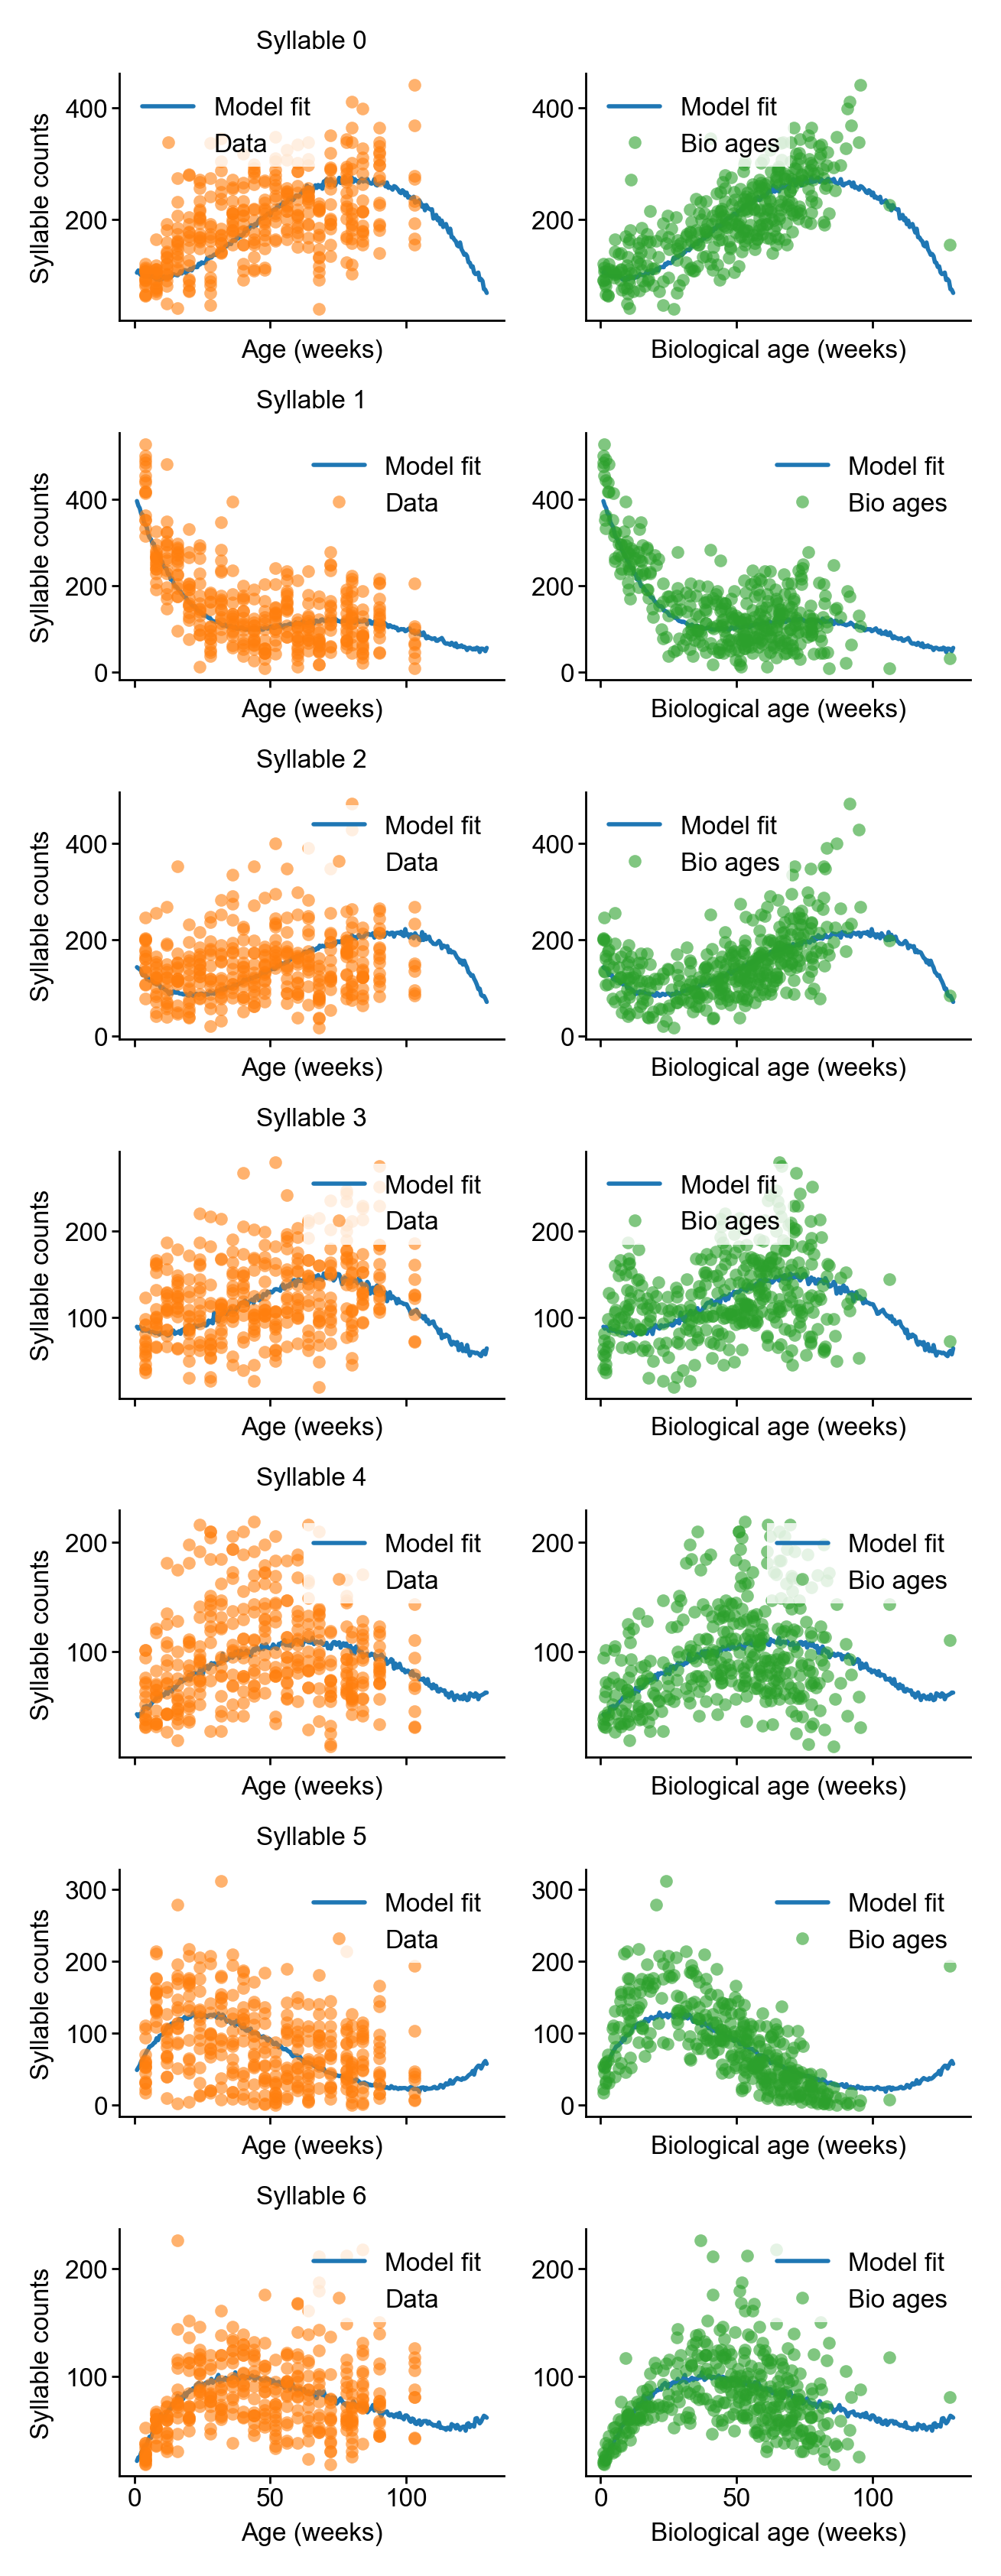

In [69]:
plot_syllables = 7
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Compare to linear regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict

In [7]:
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=5))

In [8]:
lm_bio_ages = cross_val_predict(
    pipeline, syllable_counts_jax, age, cv=StratifiedKFold(n_splits=3)
)

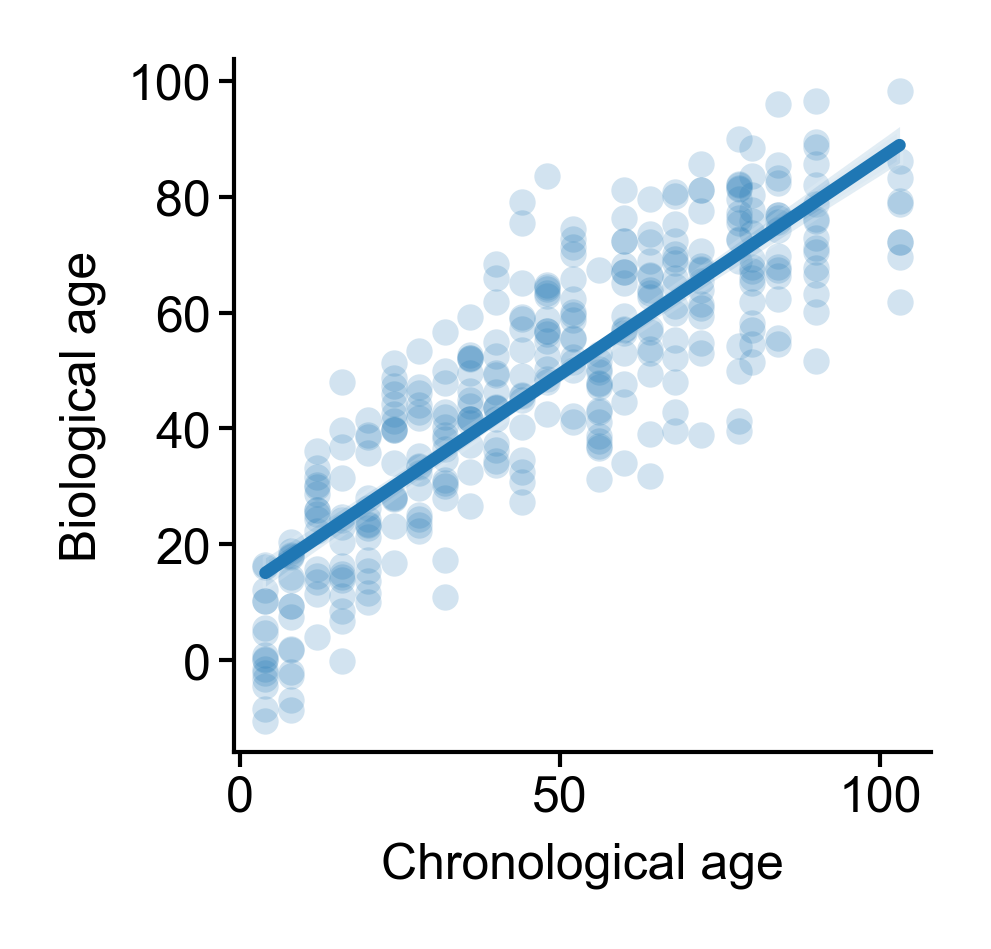

In [9]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=age, y=lm_bio_ages, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Chronological age", ylabel="Biological age")
sns.despine()

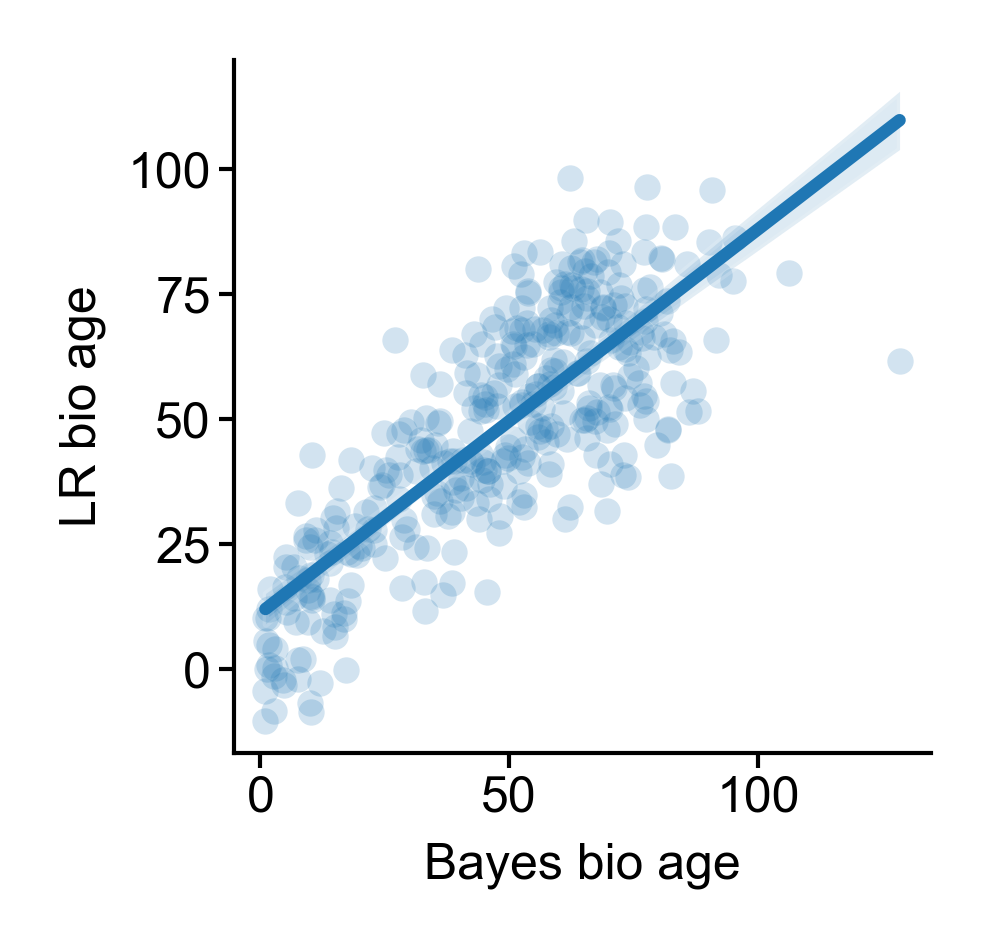

In [70]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=bio_ages, y=lm_bio_ages, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Bayes bio age", ylabel="LR bio age")
sns.despine()

In [71]:
lm_resid = age - lm_bio_ages
bio_resid = age - bio_ages

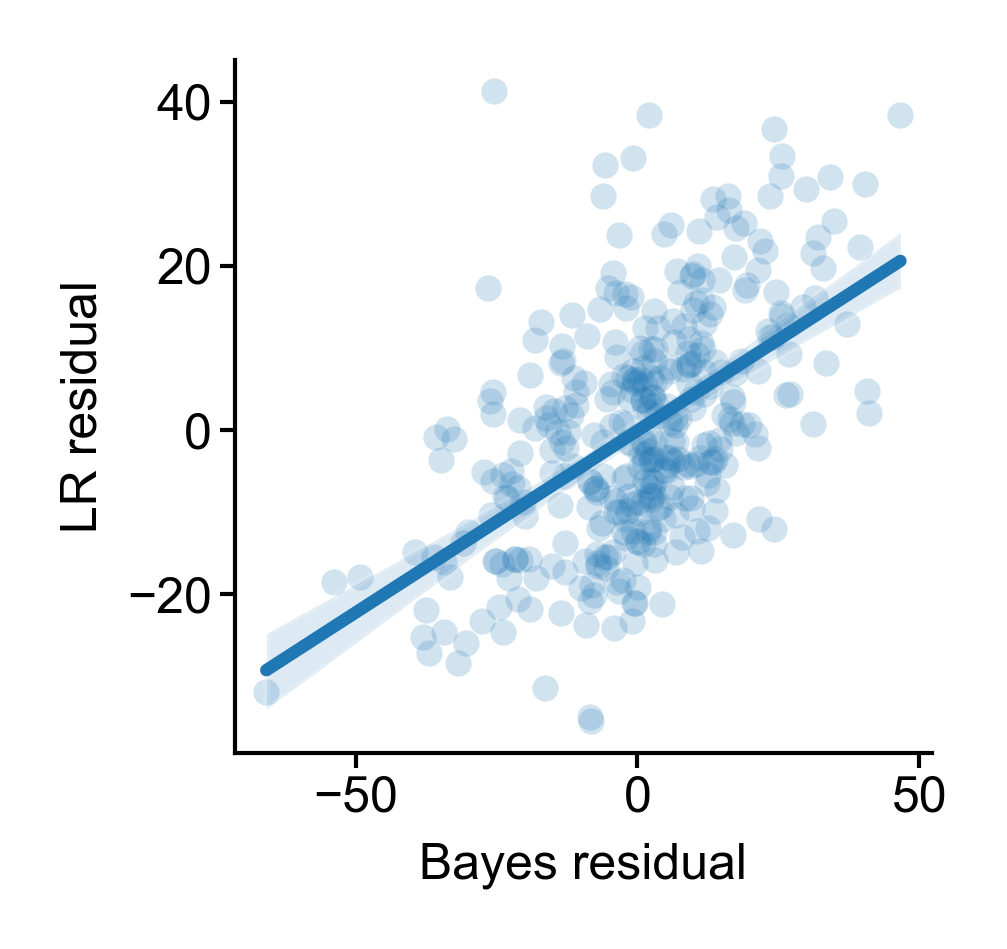

In [72]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=bio_resid, y=lm_resid, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Bayes residual", ylabel="LR residual")
sns.despine()

## Look at rank-order in longtogeny model

In [10]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)
mask = df.index.get_level_values("age") < 110
df = df[mask]

n_syllables = 40
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

In [62]:
n_splines = 5
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=95, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params(syllable_counts_jax, n_splines, age)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False
)
optimized_params, loss = optimize(params, ll_fun, lr=0.15, n_iter=150)

heldout_nll = neg_log_likelihood(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [63]:
bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

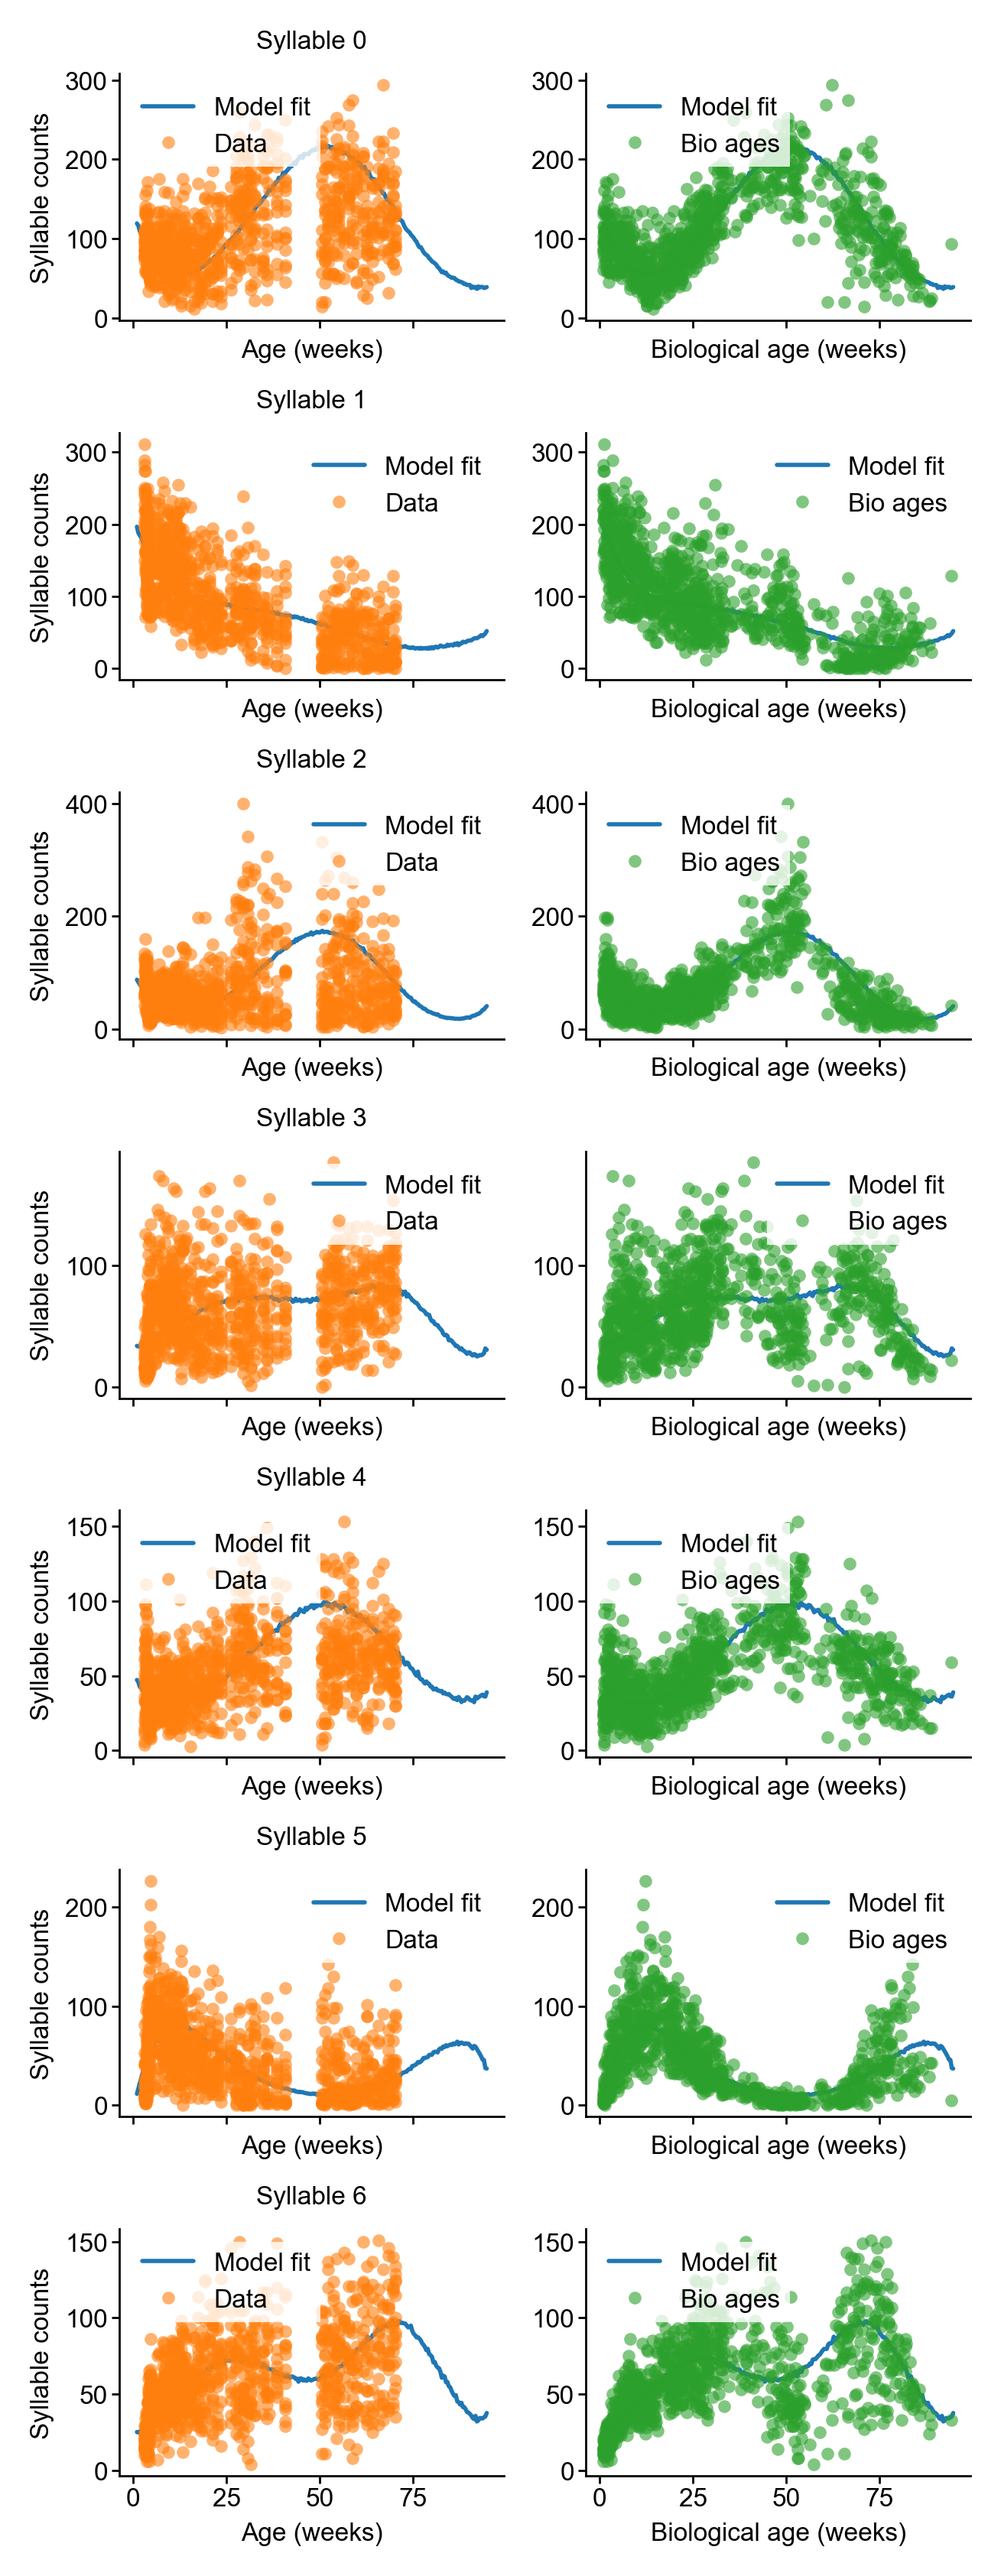

In [28]:
plot_syllables = 7
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

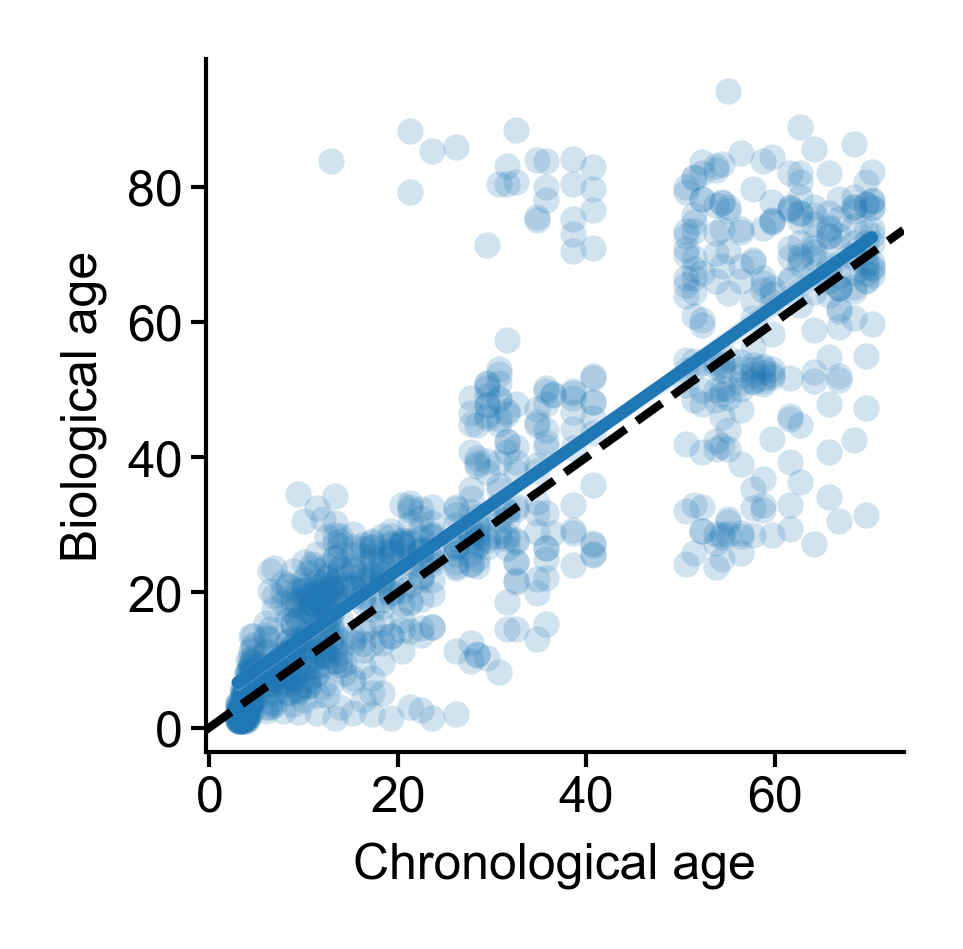

In [29]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=age, y=bio_ages, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Chronological age", ylabel="Biological age")
add_identity(ax, color="black", ls="--")
sns.despine()


In [64]:
age_df = pd.DataFrame(bio_ages, index=df.index, columns=['bio_age']).reset_index()

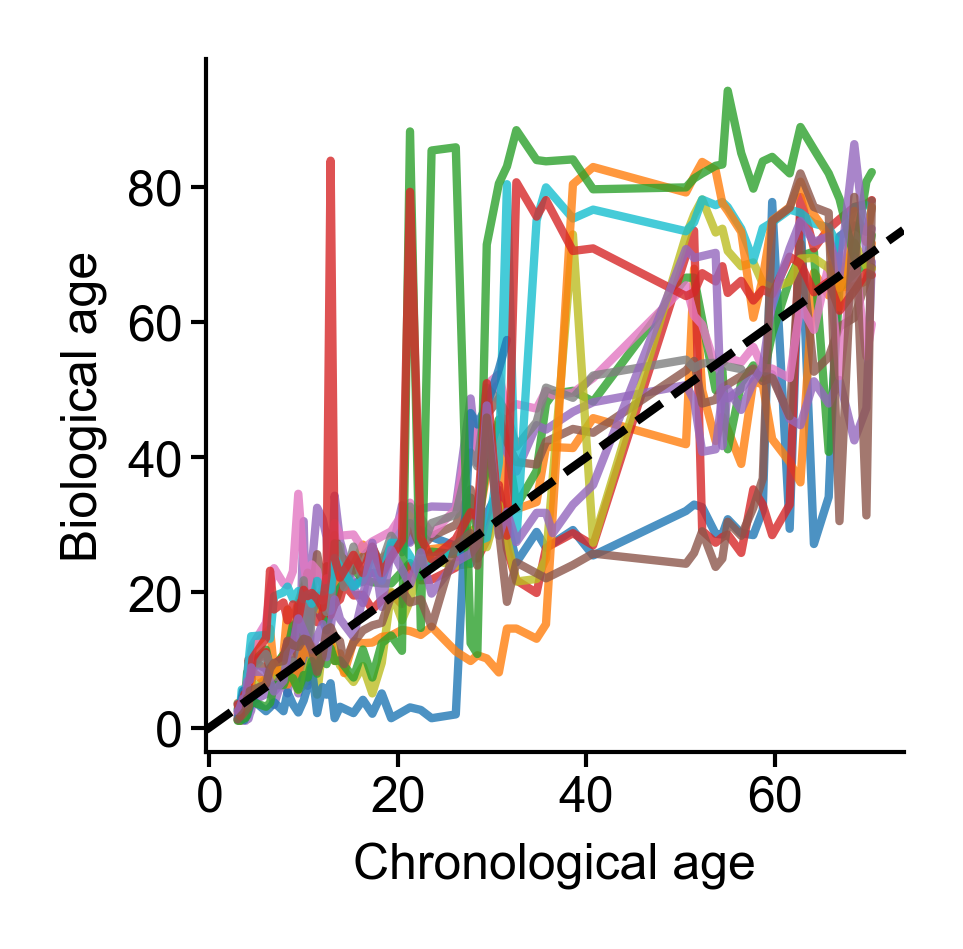

In [31]:
figure(1.5, 1.5)
for mouse, _df in age_df.groupby('mouse'):
    plt.plot(_df['age'], _df['bio_age'], alpha=0.8)
ax = plt.gca()
add_identity(ax, color="black", ls="--")
ax.set(xlabel="Chronological age", ylabel="Biological age")
sns.despine()

In [65]:
for mouse, _df in age_df.groupby('age'):
    age_df.loc[_df.index, 'age_rank'] = _df['bio_age'].rank()

Text(0, 0.5, 'Rank order')

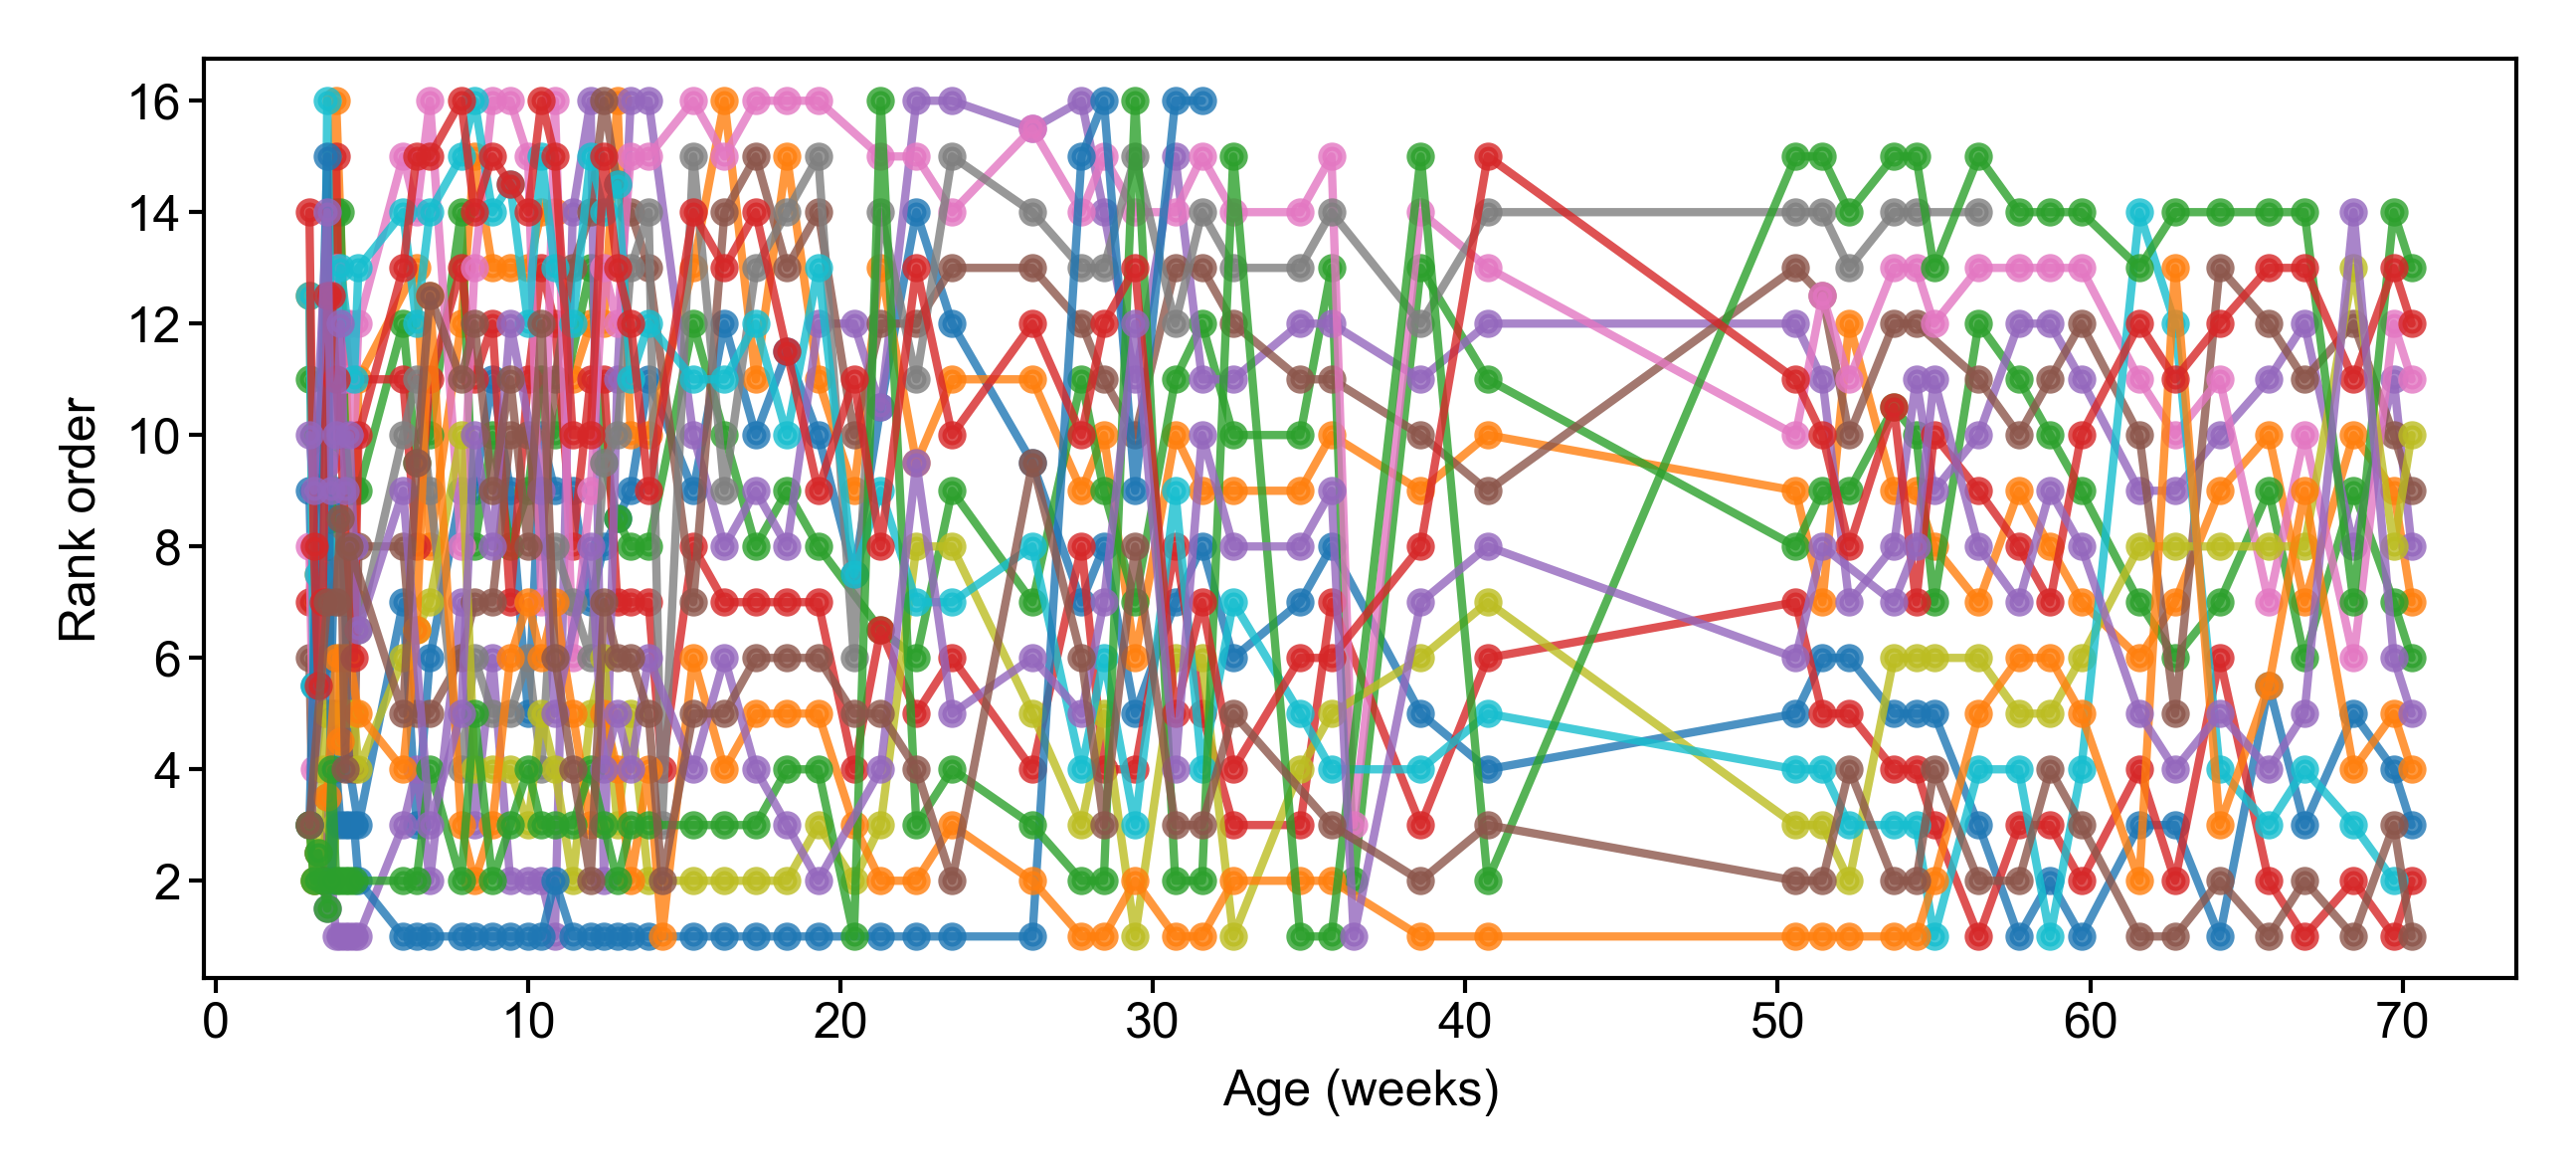

In [66]:
fig = figure(5, 2)
for mouse, _df in age_df.groupby('mouse'):
    plt.plot(_df['age'], _df['age_rank'], '.-', alpha=0.8)
plt.xlabel("Age (weeks)")
plt.ylabel("Rank order")

In [67]:
age_index_df = age_df.set_index(['age', 'mouse'])

In [68]:
ages = age_df['age'].unique()

In [69]:
def align_age(age1, age2):
    x = age_index_df.loc[age1, 'age_rank'].groupby('mouse').mean()
    y = age_index_df.loc[age2, 'age_rank'].groupby('mouse').mean()
    # index = set(x.index).intersection(set(y.index))
    index = x.index.intersection(y.index)
    return x[index], y[index]

In [70]:
counts_hist = []
avg_diffs = []
avg_corrs = []
for i in range(2, 50):
    corrs = []
    diffs = []
    for age1, age2 in zip(ages, ages[i:]):
        x, y = align_age(age1, age2)
        corr = x.corr(y)
        corrs.append(corr)
        diffs.append(age2 - age1)
    avg_diffs.append(np.median(diffs))
    avg_corrs.append(np.nanmedian(corrs))
    hist, edge = np.histogram(corrs, bins=np.linspace(-1, 1, 16))
    counts_hist.append(hist)

avg_diffs = np.array(avg_diffs)
avg_corrs = np.array(avg_corrs)
bio_age_diffs = avg_diffs.copy()
bio_age_corrs = avg_corrs.copy()

[Text(0.5, 0, 'Correlation (R)'), Text(0, 0.5, 'Age difference (weeks)')]

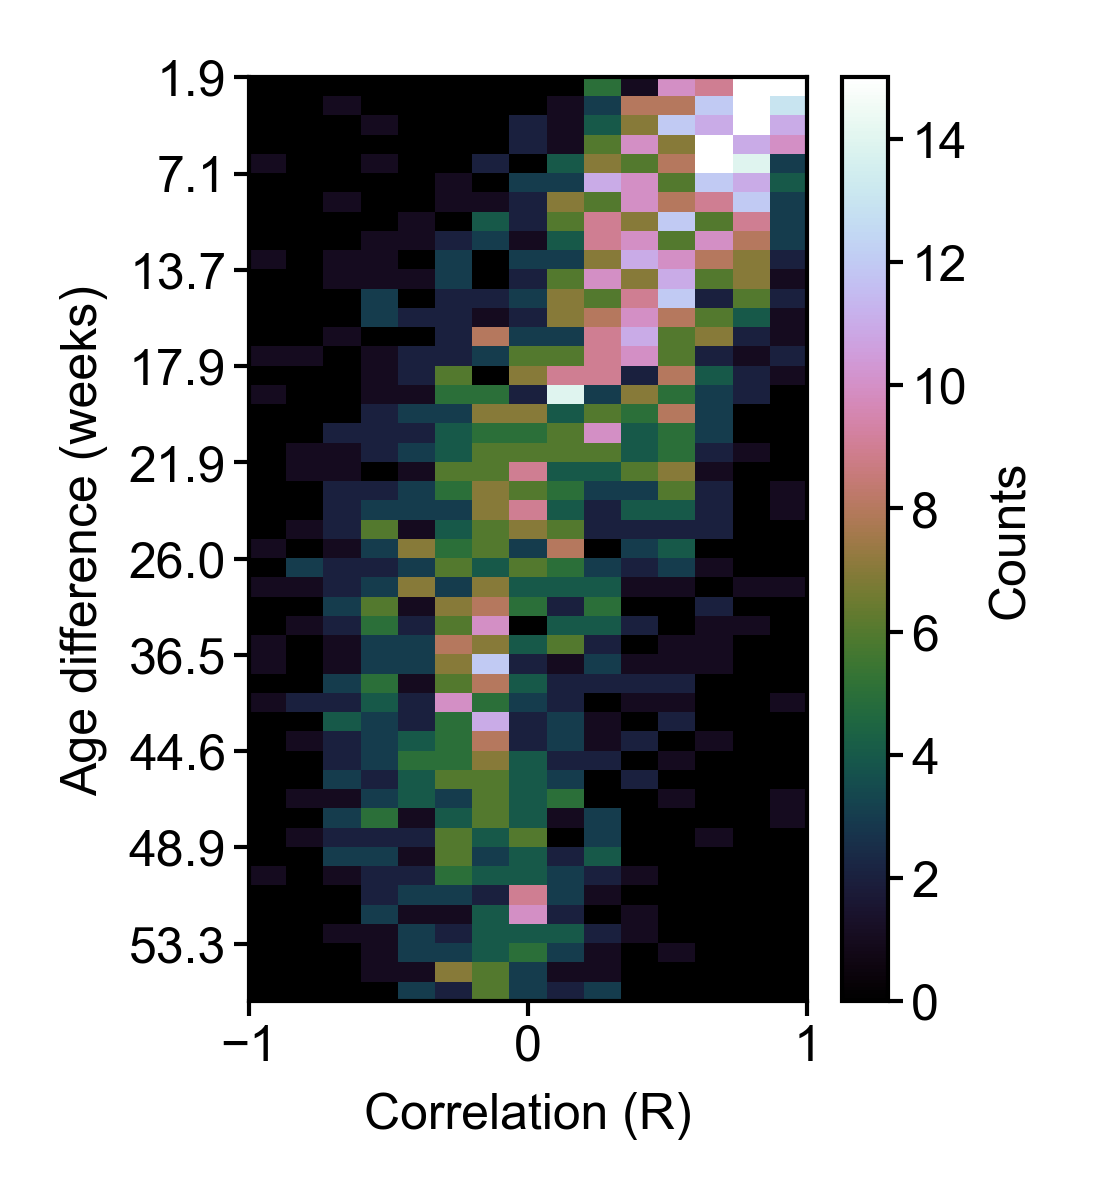

In [39]:
fig = figure(1.5, 2)
ax = fig.gca()
im = ax.imshow(
    counts_hist,
    extent=(-1, 1, 50, 2),
    aspect="auto",
    interpolation="none",
    vmax=15,
    cmap="cubehelix",
)
ax.set(yticks=np.arange(2, 50, 5), yticklabels=np.round(avg_diffs[::5], 1))
fig.colorbar(im, label="Counts")
ax.set(xlabel="Correlation (R)", ylabel="Age difference (weeks)")

### Compare longtogeny linear model to biological age model

In [41]:
from sklearn.model_selection import GroupKFold

In [72]:
lm_bio_ages = cross_val_predict(
    pipeline, syllable_counts_jax, age, groups=pd.qcut(age, 15, labels=False), cv=GroupKFold(n_splits=3)
)

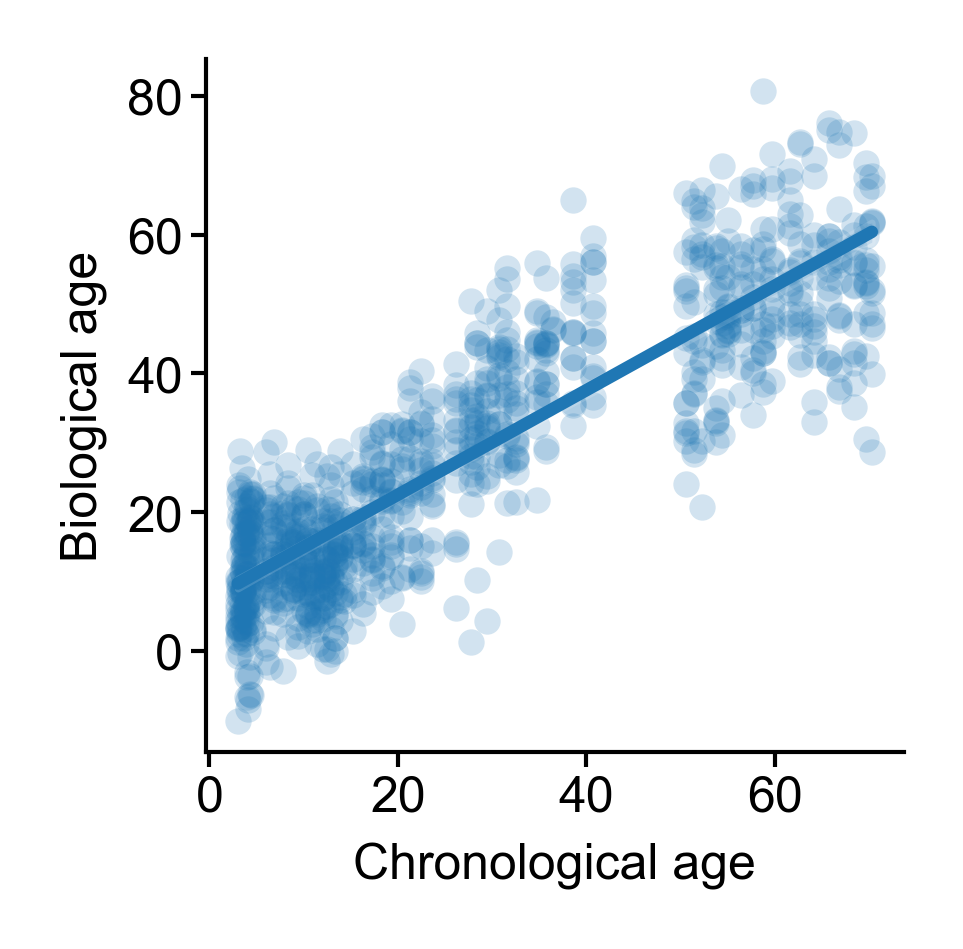

In [73]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=age, y=lm_bio_ages, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Chronological age", ylabel="Biological age")
sns.despine()

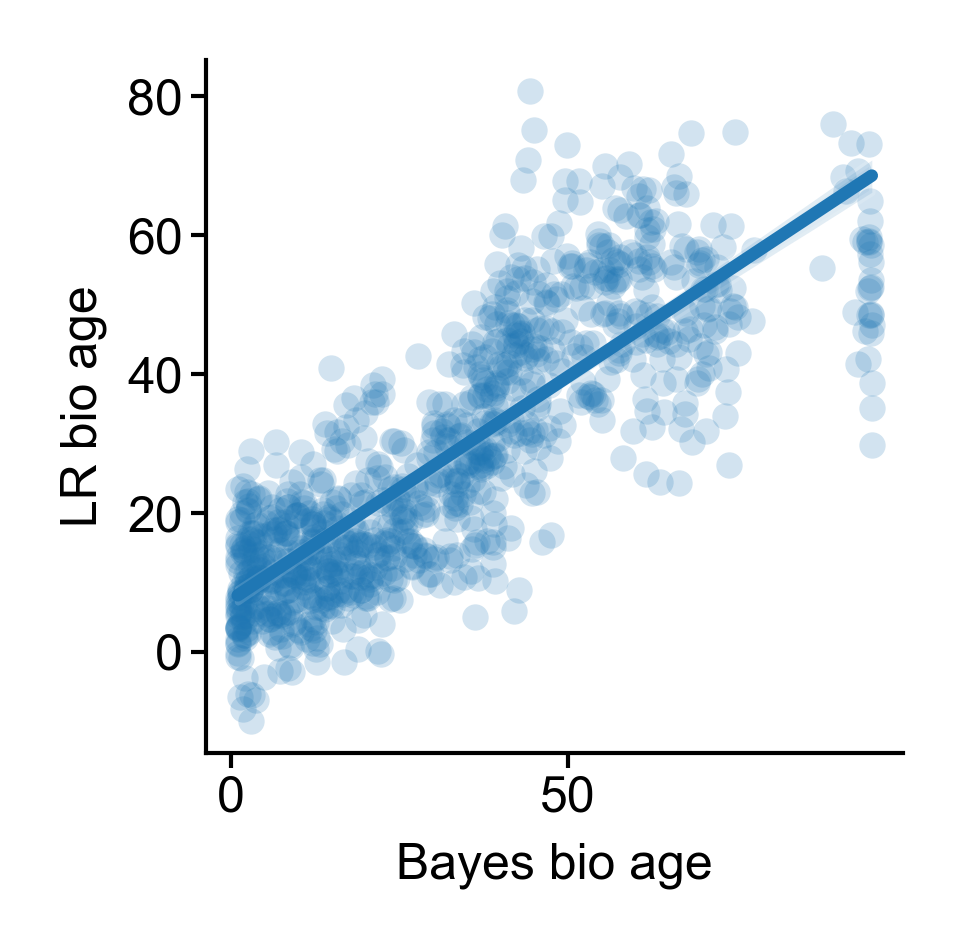

In [74]:
figure(1.5, 1.5)
ax = sns.regplot(
    x=bio_ages, y=lm_bio_ages, scatter_kws={"alpha": 0.2, "linewidths": 0, "s": 10}
)
ax.set(xlabel="Bayes bio age", ylabel="LR bio age")
sns.despine()

In [75]:
lm_age_df = pd.DataFrame(lm_bio_ages, index=df.index, columns=['lm_bio_age']).reset_index()

In [76]:
for mouse, _df in lm_age_df.groupby('age'):
    lm_age_df.loc[_df.index, 'age_rank'] = _df['lm_bio_age'].rank()

Text(0, 0.5, 'Rank order')

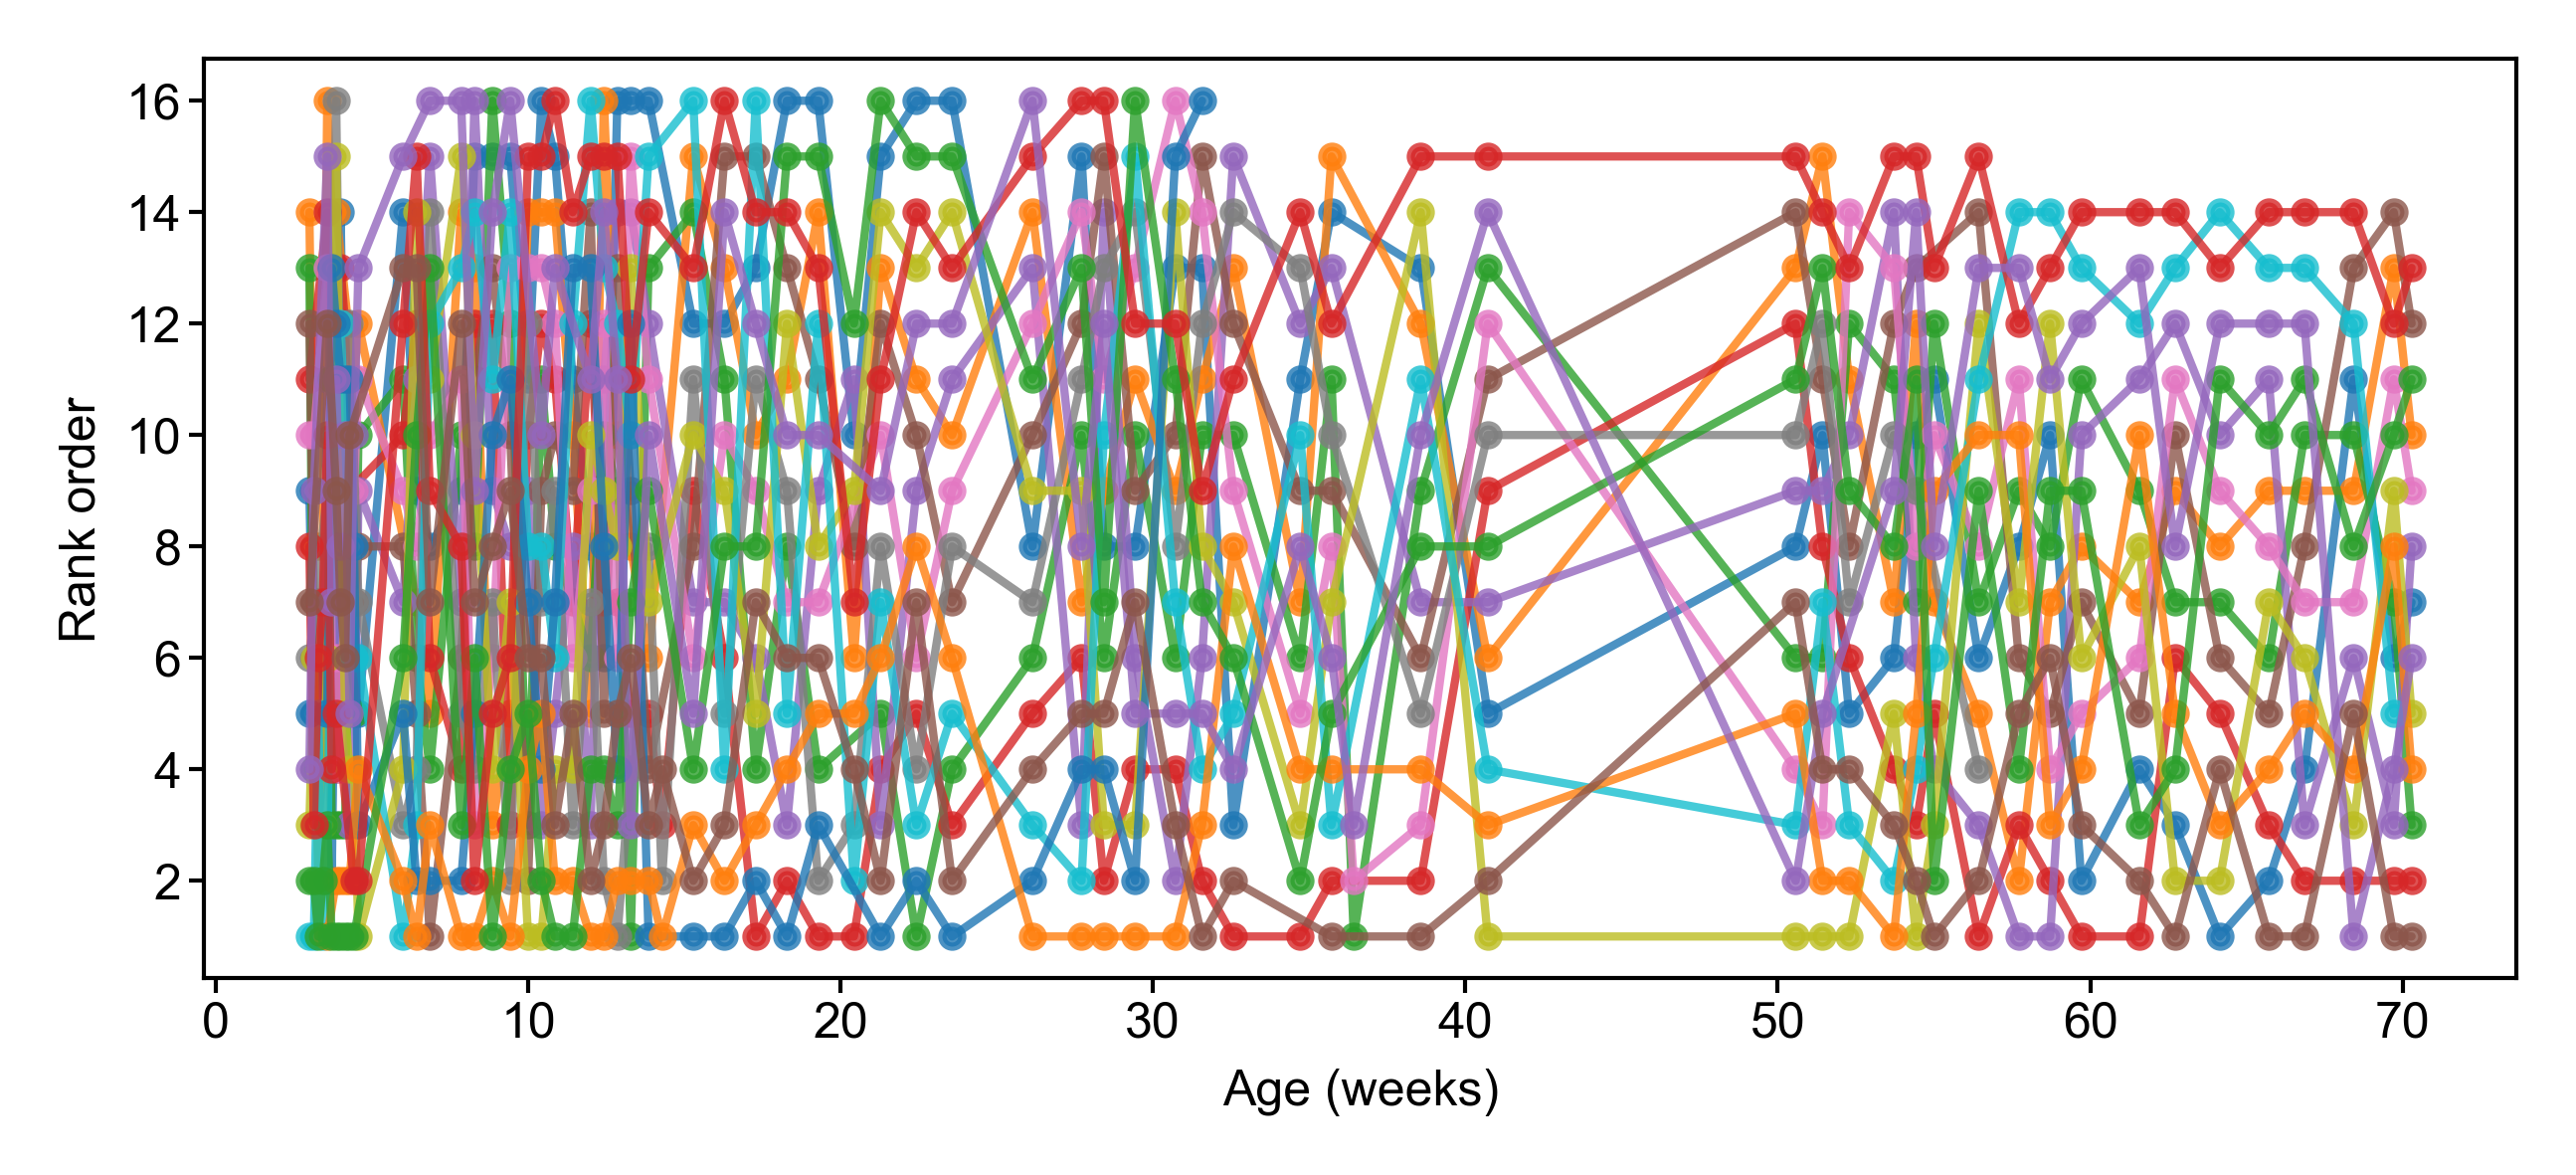

In [77]:
fig = figure(5, 2)
for mouse, _df in lm_age_df.groupby('mouse'):
    plt.plot(_df['age'], _df['age_rank'], '.-', alpha=0.8)
plt.xlabel("Age (weeks)")
plt.ylabel("Rank order")

In [78]:
age_index_df = lm_age_df.set_index(['age', 'mouse'])

In [79]:
ages = lm_age_df['age'].unique()

In [85]:
counts_hist = []
avg_diffs = []
avg_corrs = []
for i in range(2, 50):
    corrs = []
    diffs = []
    for age1, age2 in zip(ages, ages[i:]):
        x, y = align_age(age1, age2)
        corr = x.corr(y)
        corrs.append(corr)
        diffs.append(age2 - age1)
    avg_diffs.append(np.median(diffs))
    avg_corrs.append(np.nanmedian(corrs))
    hist, edge = np.histogram(corrs, bins=np.linspace(-1, 1, 16))
    counts_hist.append(hist)

avg_diffs = np.array(avg_diffs)
avg_corrs = np.array(avg_corrs)

[Text(0.5, 0, 'Correlation (R)'), Text(0, 0.5, 'Age difference (weeks)')]

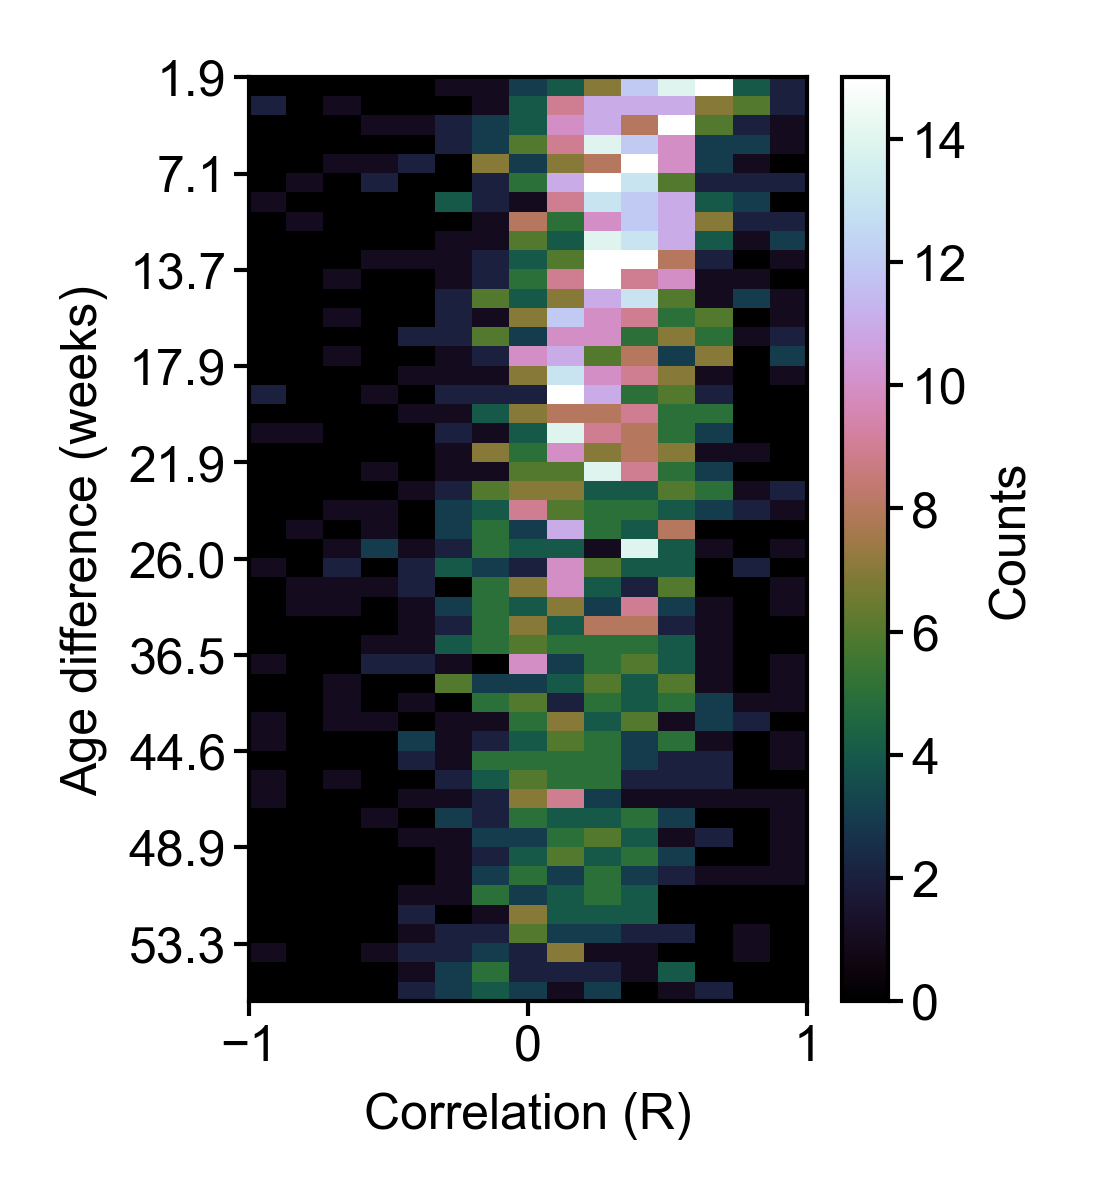

In [81]:
fig = figure(1.5, 2)
ax = fig.gca()
im = ax.imshow(
    counts_hist,
    extent=(-1, 1, 50, 2),
    aspect="auto",
    interpolation="none",
    vmax=15,
    cmap="cubehelix",
)
ax.set(yticks=np.arange(2, 50, 5), yticklabels=np.round(avg_diffs[::5], 1))
fig.colorbar(im, label="Counts")
ax.set(xlabel="Correlation (R)", ylabel="Age difference (weeks)")

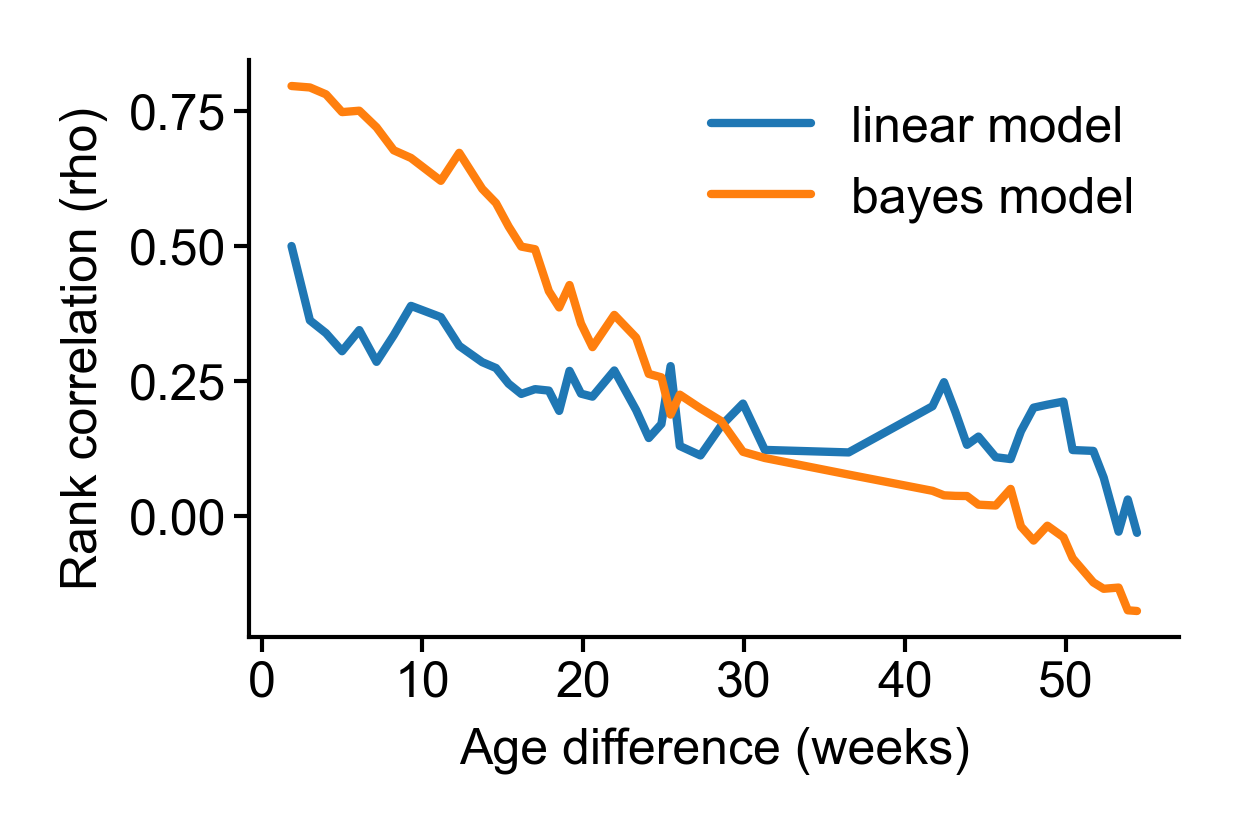

In [86]:
fig = figure(2, 1.25)
ax = fig.gca()
ax.plot(avg_diffs, avg_corrs, label="linear model")
ax.plot(bio_age_diffs, bio_age_corrs, label="bayes model")
ax.set(
    xlabel="Age difference (weeks)",
    ylabel="Rank correlation (rho)",
)
ax.legend(frameon=False)
sns.despine()